In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex4/"
save_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex4"
sys.path.append("/content/gdrive/My Drive/Colab/RRA_RL/")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

In [ ]:
def PlotPerformanceDistribution(*args, **kwargs):
    '''
    Add distribution of one model (with its set of risk measure params) to a plot
    :param args: distribution passed in separately, each is a numpy of (Nsim, ) vector
    :param kwargs: alpha, beta, p, all as list. use this to find out a, b, p, rm_type = self.rm_params.GetParams()
    :return: 1 figure with all the distributions visualized as kde, and dot line showing the mean
    '''
    # Initialize an empty list to store DataFrames
    distributions_list = []
    means = np.ones(len(args))
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    alphas = kwargs.get('alpha', [])
    betas = kwargs.get('beta', [])
    ps = kwargs.get('p', [])
    market_type = kwargs.get('market_type', 'Bull')

    handles = []  # List to store handles for legends
    labels = []   # List to store labels for legends

    for index, item in enumerate(args):
        # format distribution as a dataframe
        x_phi = item
        alpha = alphas[index]
        beta = betas[index]
        p = ps[index]
        temp = pd.DataFrame({'x': x_phi, 'risk_distortion_parameters': r'$\alpha={},\beta={},p={}$'.format(alpha, beta, p)})
        means[index] = np.mean(x_phi)

        # append the DataFrame to the list
        distributions_list.append(temp)

    # concatenate the list of DataFrames
    distributions = pd.concat(distributions_list, ignore_index=True)

    # plot all distributions in 1 graph
    plot = sns.displot(data=distributions,
                    x='x',
                    hue='risk_distortion_parameters',
                    kind='kde',
                    fill=True,
                    palette=colors[:len(args)],
                    height=5, aspect=1.5)

    # plot the average of all distributions as vertical lines with labels
    for index in range(len(args)):
        plt.axvline(means[index], ls='--', alpha=1, color=colors[index], label=f'Mean {index + 1}')

    # Extract handles and labels from the legend
    for i, text in enumerate(plot._legend.texts):
        handles.append(plot._legend.legendHandles[i])
        labels.append(text.get_text())

    # remove default legend, replace it with customized one
    plot._legend.remove()
    plt.legend(handles, labels, loc='center right', fontsize=10)
    # other annotations
    plt.xlabel(r'$X_{\phi}: portfolio~terminal~value$', fontsize=10)
    plt.title('{} Market Performance Under Different Risk Preferences'.format(market_type))
    plt.show()


In [ ]:
val075 = np.load(save_dir + '/save075/' + 'daily_asset_value_history.npy')[-1]
val090 = np.load(save_dir + '/save090/' + 'daily_asset_value_history.npy')[-1]
val100 = np.load(save_dir + '/save100/' + 'daily_asset_value_history.npy')[-1]

val075 = np.sum(val075[-1, :, :], axis=1)
val090 = np.sum(val090[-1, :, :], axis=1)
val100 = np.sum(val100[-1, :, :], axis=1)

<ipython-input-4-c8ec5f8b979c>:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles.append(plot._legend.legendHandles[i])


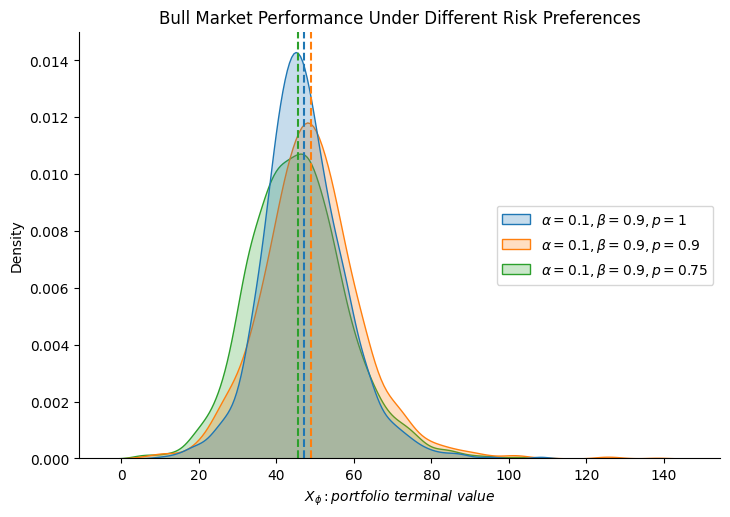

In [ ]:
PlotPerformanceDistribution(val100, val090, val075, alpha=[0.1, 0.1, 0.1], beta=[0.9, 0.9, 0.9], p=[1, 0.9, 0.75], market_type='Bull')

In [ ]:
val075 = np.load(save_dir + '(bear)/save075/' + 'daily_asset_value_history.npy')[-1]
val090 = np.load(save_dir + '(bear)/save090/' + 'daily_asset_value_history.npy')[-1]
val100 = np.load(save_dir + '(bear)/save100/' + 'daily_asset_value_history.npy')[-1]

val075 = np.sum(val075[-1, :, :], axis=1)
val090 = np.sum(val090[-1, :, :], axis=1)
val100 = np.sum(val100[-1, :, :], axis=1)

<ipython-input-4-c8ec5f8b979c>:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles.append(plot._legend.legendHandles[i])


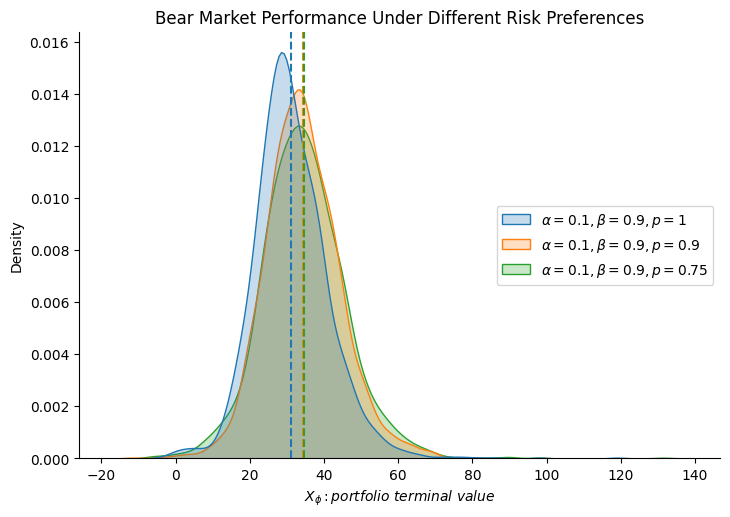

In [ ]:
PlotPerformanceDistribution(val100, val090, val075, alpha=[0.1, 0.1, 0.1], beta=[0.9, 0.9, 0.9], p=[1, 0.9, 0.75], market_type='Bear')

In [ ]:
def PlotAssetAllocation(*args, **kwargs):
    '''
    Plot asset allocation over time for a given series of x_phi arrays.
    :param ags: a series of x_phi (Ndt+1, Nsim, Nasset), separated by ,
    :param kwargs: alpha, beta, p, all as list. use this to find out a, b, p, rm_type = self.rm_params.GetParams()
    :              type: how to select allocation to draw (e.g. avg of all simulations, the best-performing simulation, etc). {"average", "best", "worst"}, by default is "average"
    :              indices: if type equals 'best" or "worst", a list of indices is required.
    :return: 1 stacked bar chart, x-axis is normalized trading date, y-axis is allocated weight for each asset
    '''
    # read in arguments passed into the function
    k = len(args)
    Nassets = args[0].shape[2]
    sim_type = kwargs.get('type', 'average')
    sim_indices = kwargs.get('indices', [])
    alphas = kwargs.get('alpha', [])
    betas = kwargs.get('beta', [])
    ps = kwargs.get('p', [])  # when p = 1, distortion reduces to Conditional-Value-at-Risk at level alpha
    x_phis = []

    # pre-treat allocation data according to sim_type passed in
    if sim_type == 'average':  # average over all simulations
        for index, item in enumerate(args):
            x_phis.append(np.mean(item, axis=1))  # each x_phi appended to the list is of (Ndt, Nasset)
    elif sim_type in ('best', 'worst'):
        for index, item in enumerate(args):
            x_phis.append(item[:, sim_indices[index], :])  # each x_phi appended to the list is of (Ndt, Nasset)
    else:
        raise Exception('this type is not supported')


    # plot
    color_names = [  # color map (unique colors for to 10 distributions)
     'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    fig, axs = plt.subplots(1, k, figsize=(15, 5))
    legend_handles = []  # to store handles for legend
    asset_names = ['asset ' + str(a + 1) for a in range(Nassets)]

    for i in range(k):  # iterate through given x_phi's
        # reformat x_phis for stacked plot purpose
        stacked_areas = axs[i].stackplot(range(x_phis[i].shape[0]), x_phis[i].T, colors=color_names)
        if i == k-1:
            for area, name in zip(stacked_areas, asset_names):
                legend_handles.append(Patch(color=area.get_facecolor(), label=name))

        axs[i].set_title(r'Allocation at $\alpha={},\beta={},p={}$'.format(alphas[i], betas[i], ps[i]))
        axs[i].set_xlabel('trading period')
        axs[i].set_ylabel(r'$\phi portfolio weights$')

    # Place a common legend outside the subplots
    fig.legend(handles=legend_handles,  bbox_to_anchor=(0.98, 0.7), borderaxespad=0., title='Assets')
    plt.show()


In [ ]:
bull075 = np.load(save_dir + '/save075/' + 'wt_history.npy')[-1]
bull090 = np.load(save_dir + '/save090/' + 'wt_history.npy')[-1]
bull100 = np.load(save_dir + '/save100/' + 'wt_history.npy')[-1]

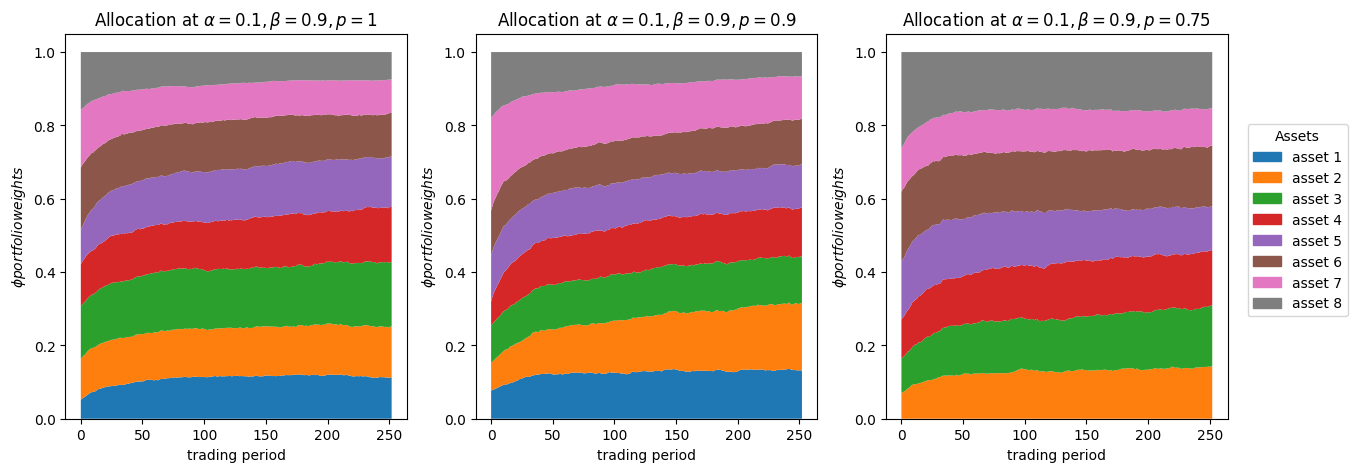

In [ ]:
PlotAssetAllocation(bull100, bull090, bull075, type='average', alpha=[0.1, 0.1, 0.1], beta=[0.9, 0.9, 0.9], p=[1, 0.9, 0.75])

In [ ]:
bear075 = np.load(save_dir + '(bear)/save075/' + 'wt_history.npy')[-1]
bear090 = np.load(save_dir + '(bear)/save090/' + 'wt_history.npy')[-1]
bear100 = np.load(save_dir + '(bear)/save100/' + 'wt_history.npy')[-1]

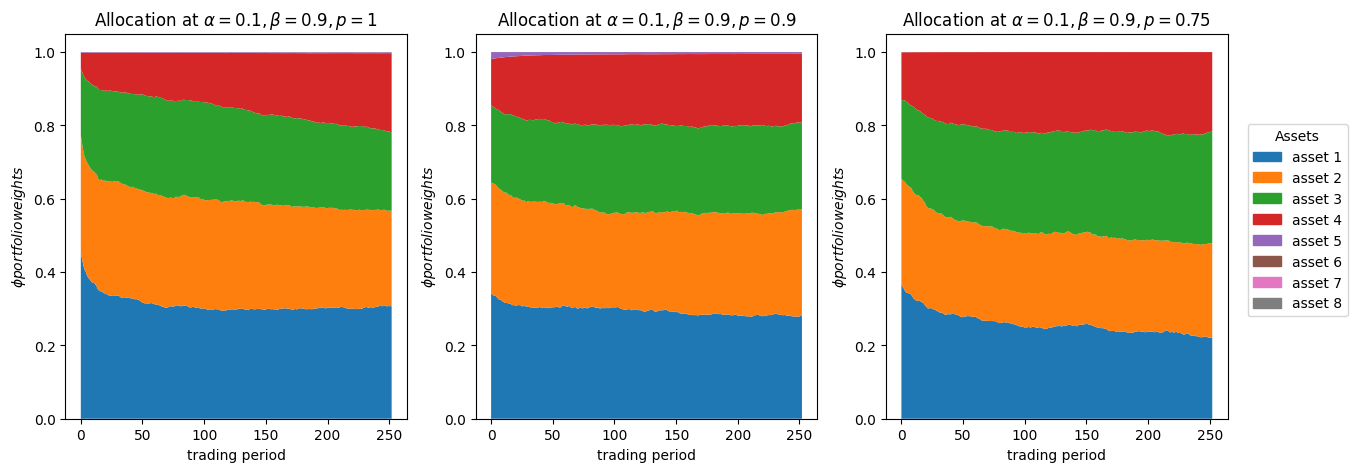

In [ ]:
PlotAssetAllocation(bear100, bear090, bear075, type='average', alpha=[0.1, 0.1, 0.1], beta=[0.9, 0.9, 0.9], p=[1, 0.9, 0.75])